# Annual cycles
env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 252 GB / available: 176 GB / percent used: 30.1 %


# Load model data

In [2]:
# Define period
period = slice('1982','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Snow cover 

## Load ensemble mean

In [3]:
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'

realization = 'ens'
# Load historical ens
experiment='historical'
snc_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)
# Load amip ens
experiment='amip'
snc_amip = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
snc_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load land-hist
snc_land_hist_cruNcep = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist-cruNcep/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
snc_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

## Load obs

### NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

In [4]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)

In [5]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
obs.attrs['units'] = '%'

# Rename lon and lat for the regrid
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
snc_obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(snc_obs, snc_historical, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
print(regridder_obs)

# Regrid the data
snc_obs_regrid = regridder_obs(snc_obs)

Reuse existing file: bilinear_88x88_143x144.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? True 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


### Regrid HR

In [7]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(snc_HR, snc_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_HR)

# Regrid the data
snc_HR_regrid = regridder_HR(snc_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


### ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

In [8]:
root_data_path = '/data/mlalande/'
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_1deg/*.nc').sel(time=period)
# Check if the time steps are ok
# np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
# Attention il manque des mois (donc plutôt faire un groupby month avant de faire la climatologie)

snow_cci_interp = ds['scfg_interp_1deg_icefilled']
snow_cci_interp = snow_cci_interp.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
snow_cci_interp.load()
snow_cci_interp.loc['1994-10'] = snow_cci_interp.loc['1994-11'].values # set to nan all values from '1994-10' because of too much missing values leading to wrong spatial average
# snow_cci_interp['time'] = noaa_cdr_2.time

In [9]:
regridder = xe.Regridder(snow_cci_interp, snc_historical, 'bilinear', periodic=True, reuse_weights=True)
snow_cci_interp_regrid = regridder(snow_cci_interp)

Reuse existing file: bilinear_180x360_143x144_peri.nc


# Temperature

In [10]:
var = 'tas'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'

realization = 'ens'
# Load historical ens
experiment='historical'
tas_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)
# Load amip ens
experiment='amip'
tas_amip = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
tas_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
tas_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

tas_historical = tas_historical-273.15
tas_amip = tas_amip-273.15
tas_land_hist = tas_land_hist-273.15
tas_HR = tas_HR-273.15

# Load obs

## cru_ts4.04
https://crudata.uea.ac.uk/cru/data/hrg/  

In [11]:
ds = xr.open_dataset('/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc') \
        .sel(time=period)
tas_obs = ds.tmp

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [12]:
regridder_obs = xe.Regridder(tas_obs, tas_historical, 'bilinear', periodic=True, reuse_weights=True)
tas_obs_regrid = regridder_obs(tas_obs)

Reuse existing file: bilinear_360x720_143x144_peri.nc


### Regrid HR

In [13]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(tas_HR, tas_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_HR)

# Regrid the data
tas_HR_regrid = regridder_HR(tas_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


# Precipitation

## Load ensemble mean

In [14]:
var = 'pr'
# var = 'prsn'
if var in ['tas', 'pr', 'prsn']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'
    
realization = 'ens'
# Load historical ens
experiment='historical'
pr_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)
# Load amip ens
experiment='amip'
pr_amip = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
pr_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
pr_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

pr_historical = pr_historical*86400
pr_amip = pr_amip*86400
pr_land_hist = pr_land_hist*86400
pr_HR = pr_HR*86400

In [15]:
var = 'prsn'
realization = 'ens'
# Load historical ens
experiment='historical'
pr_historical_sn = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)
# Load amip ens
experiment='amip'
pr_amip_sn = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
pr_land_hist_sn = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
pr_HR_sn = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# To mm/day
pr_historical_sn = pr_historical_sn*86400
pr_amip_sn = pr_amip_sn*86400
pr_land_hist_sn = pr_land_hist_sn*86400
pr_HR_sn = pr_HR_sn*86400

## Load obs

### APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

In [33]:
obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip

obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')

pr_obs = obs.resample(time='1MS').mean('time').sel(time=period)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [34]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(pr_obs, pr_historical, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
print(regridder_obs)

# Regrid the data
pr_obs_regrid = regridder_obs(pr_obs)

Reuse existing file: bilinear_140x180_143x144.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_140x180_143x144.nc 
Reuse pre-computed weights? True 
Input grid shape:           (140, 180) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


### Regrid HR

In [18]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(pr_HR, pr_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_HR)

# Regrid the data
pr_HR_regrid = regridder_HR(pr_HR)
pr_HR_sn_regrid = regridder_HR(pr_HR_sn)

Reuse existing file: bilinear_361x512_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


## Load ERA-Interim

In [19]:
era = xr.open_mfdataset('/data/mlalande/ERAI/tp/tp_ERAI_*.nc', combine='by_coords').tp.sel(time=period).load()
# mm/day
era = era.rename({'longitude': 'lon', 'latitude': 'lat'})
era = era*1000
regridder_ERAI = xe.Regridder(era, pr_historical, 'bilinear', periodic=True, reuse_weights=True)
era_regrid = regridder_ERAI(era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## GPCP CDR v2.3 (2.5°)
https://www.ncdc.noaa.gov/cdr/atmospheric/precipitation-gpcp-monthly

In [20]:
ds = xr.open_mfdataset(
    '/data/mlalande/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period)

gpcp = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

In [21]:
# Make the regrider
regridder_obs = xe.Regridder(gpcp, pr_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_obs)

# Regrid the data
gpcp_regrid = regridder_obs(gpcp)

Reuse existing file: bilinear_72x144_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_72x144_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (72, 144) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


## Topo

In [22]:
orog = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
).load()

In [26]:
orog

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 ,
        2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2658.9578, 2668.209 ,
        2677.9058],
       [2618.7102, 2638.589 , 2658.8015, ..., 2562.443 , 2580.6404,
        2599.4429],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

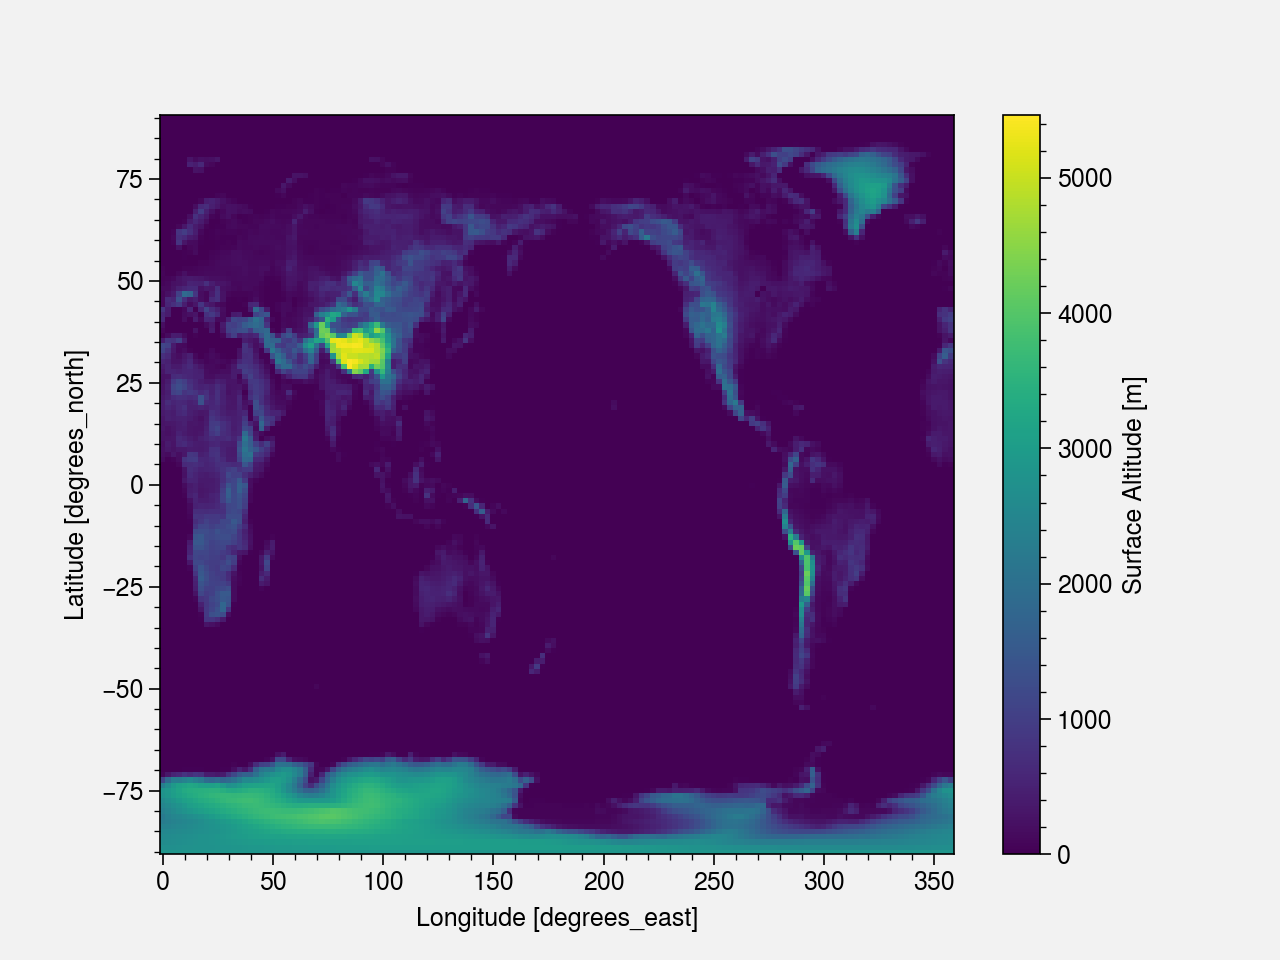

In [24]:
orog.plot()

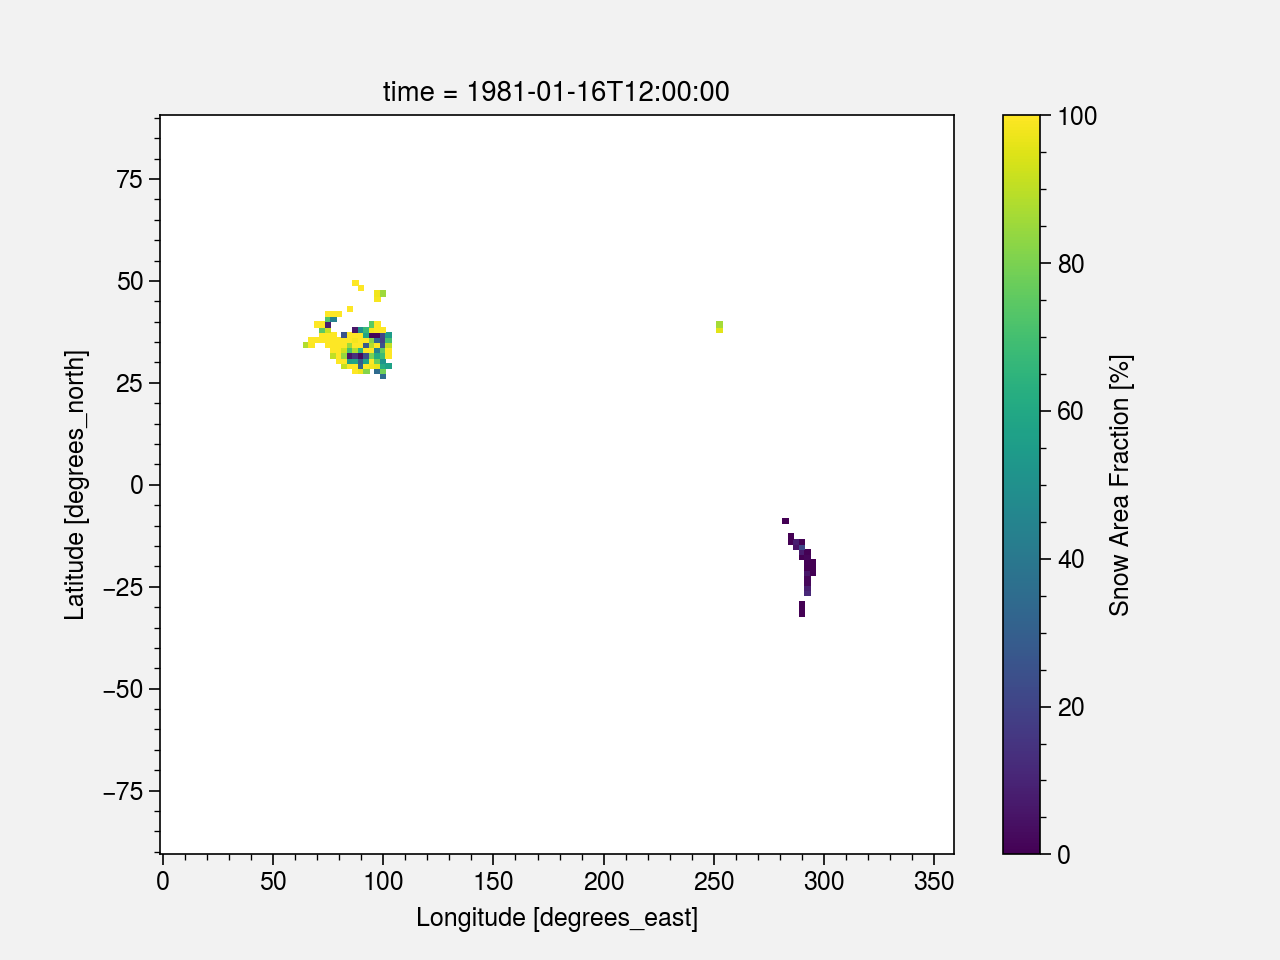

In [29]:
snc_historical[0].where(orog > 2500).plot()

# Annual cycle

In [23]:
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones_IPSL_CM6A_LR()

titles = ['HK', 'HM', 'TP']
zone_slices = [
    [slice(lonlim_HK[0],lonlim_HK[1]), slice(latlim_HK[0],latlim_HK[1])],
    [slice(lonlim_HM[0],lonlim_HM[1]), slice(latlim_HM[0],latlim_HM[1])],
    [slice(lonlim_TP[0],lonlim_TP[1]), slice(latlim_TP[0],latlim_TP[1])]
]

In [24]:
idx = pd.MultiIndex.from_product([['tas', 'snc', 'pr', 'rain'],
                                  ['hist', 'amip', 'land', 'hr']],
                                 names=['var', 'exp'])
col = pd.Index(['HK', 'HM', 'TP'], name='zone')

df = pd.DataFrame(index=idx, columns=col)
df

zone        HK   HM   TP
var  exp                
tas  hist  NaN  NaN  NaN
     amip  NaN  NaN  NaN
     land  NaN  NaN  NaN
     hr    NaN  NaN  NaN
snc  hist  NaN  NaN  NaN
     amip  NaN  NaN  NaN
     land  NaN  NaN  NaN
     hr    NaN  NaN  NaN
pr   hist  NaN  NaN  NaN
     amip  NaN  NaN  NaN
     land  NaN  NaN  NaN
     hr    NaN  NaN  NaN
rain hist  NaN  NaN  NaN
     amip  NaN  NaN  NaN
     land  NaN  NaN  NaN
     hr    NaN  NaN  NaN

In [25]:
tas_exp = [tas_historical, tas_amip, tas_land_hist, tas_HR_regrid]
snc_exp = [snc_historical, snc_amip, snc_land_hist, snc_HR_regrid]
pr_exp = [pr_historical, pr_amip, pr_land_hist, pr_HR_regrid]
pr_exp_rain = [pr_historical-pr_historical_sn, pr_amip-pr_amip_sn, pr_land_hist-pr_land_hist_sn, pr_HR_regrid-pr_HR_sn_regrid]


In [26]:
for var, var_exp in zip(['tas', 'snc', 'pr', 'rain'], [tas_exp, snc_exp, pr_exp, pr_exp_rain]):
    print(var)
    for i_exp, exp in enumerate(['hist', 'amip', 'land', 'hr']):
        print(exp)
        for i, zone in enumerate(['HK', 'HM', 'TP']):
            print(zone)
            df.loc[var, exp][zone] = (u.spatial_average(var_exp[i_exp].sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500))).groupby('time.month').mean()

tas
hist
HK
HM
TP
amip
HK
HM
TP
land
HK
HM
TP
hr
HK
HM
TP
snc
hist
HK
HM
TP
amip
HK
HM
TP
land
HK
HM
TP
hr
HK
HM
TP
pr
hist
HK
HM
TP
amip
HK
HM
TP
land
HK
HM
TP
hr
HK
HM
TP
rain
hist
HK
HM
TP
amip
HK
HM
TP
land
HK
HM
TP
hr
HK
HM
TP


tas
HK
HM
TP
snc
HK
HM
TP
pr
HK


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


HM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TP


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


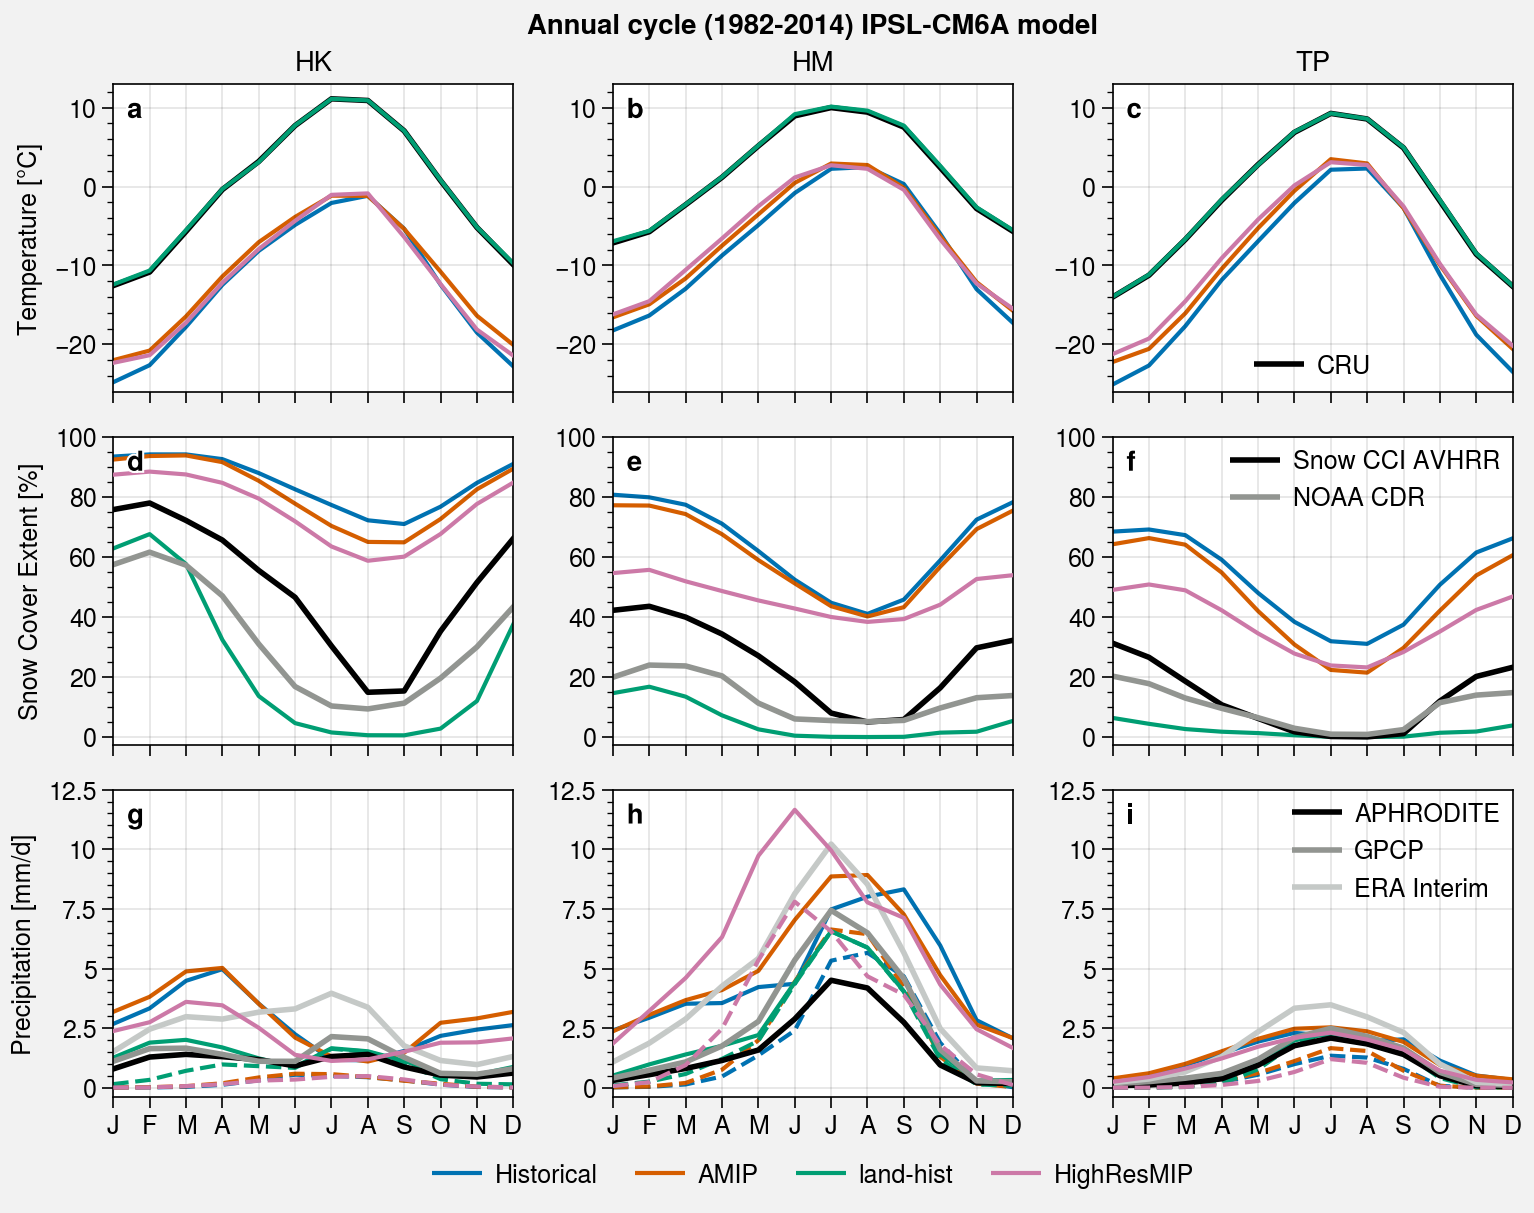

In [47]:
f, axs = plot.subplots(ncols=3, nrows=3, aspect=1.3, axwidth=2, sharey=0)

labels_exp = ['Historical', 'AMIP', 'land-hist', 'HighResMIP']
hs = []

k = 0
for var in ['tas', 'snc', 'pr']:
    print(var)  
    for i, zone in enumerate(['HK', 'HM', 'TP']):
        print(zone)
        ax = axs[k, i]
        for i_exp, exp in enumerate(['hist', 'amip', 'land', 'hr']):
            h = df.loc[var, exp][zone].plot(ax=ax, label=labels_exp[i_exp], zorder=i_exp)
            if var == 'pr':
                df.loc['rain', exp][zone].plot(ax=ax, zorder=i_exp, ls='--', color='C'+str(i_exp))
            if (var == 'snc') and (zone == 'HK'): hs.append(h)
        if var == 'tas': 
            ac_obs_tas = (u.spatial_average(tas_obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500))).groupby('time.month').mean()
            h1_tas = ac_obs_tas.plot(ax=ax, color='black', linewidth=2, label='CRU', zorder=0)
            ax.format(ylim=(-26, 13)) 
        if var == 'snc': 
            ax.format(ylim=(-2.5, 100))
            ac_obs_snc = (u.spatial_average(snc_obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500))).groupby('time.month').mean()
            h1_snc = ac_obs_snc.plot(ax=ax, color='black', linewidth=2, label='Snow CCI AVHRR')
            ac_obs_snow_cci = snow_cci_interp_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500).weighted(np.cos(np.deg2rad(snow_cci_interp_regrid.lat))).mean(('lat', 'lon')).groupby('time.month').mean()
            h2_snc = ac_obs_snow_cci.plot(ax=ax, color='gray', linewidth=2, label='NOAA CDR') 
        if var == 'pr': 
            ac_obs_pr = (u.spatial_average(pr_obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500))).groupby('time.month').mean()
            h1_pr = ac_obs_pr.plot(ax=ax, color='black', linewidth=2, label='APHRODITE')
            ac_obs_gpcp = gpcp_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500).weighted(np.cos(np.deg2rad(gpcp_regrid.lat))).mean(('lat', 'lon')).groupby('time.month').mean()
            h2_pr = ac_obs_gpcp.plot(ax=ax, color='gray', linewidth=2, label='GPCP') 
            ac_obs_era = era_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).where(orog > 2500).weighted(np.cos(np.deg2rad(era_regrid.lat))).mean(('lat', 'lon')).groupby('time.month').mean()
            h3_pr = ac_obs_era.plot(ax=ax, color='silver', linewidth=2, label='ERA Interim')
            ax.format(ylim=(-0.4, 12.5))
        ax.format(title='')
            
    k += 1
            
axs[0, 2].legend([h1_tas], frame=False, ncols=1, loc='lc')
axs[1, 2].legend([h1_snc, h2_snc], frame=False, ncols=1, loc='ur')
axs[2, 2].legend([h1_pr, h2_pr, h3_pr], frame=False, ncols=1, loc='ur')
                          
#     h3 = sa_land_hist.groupby('time.month').mean().plot(ax=ax, label='land-hist', zorder=10)
#     h5 = sa_obs_regrid.groupby('time.month').mean().plot(ax=ax, label='Snow CCI AVHRR', color='black', linewidth=2)    
#     h6 = ac_era_regrid.plot(ax=ax, label='ERA-Interim', color='dark', linestyle='--')

for i, title in enumerate(['HK', 'HM', 'TP']):
    axs[i].format(title=title)

for i, ylabel in enumerate(['Temperature [°C]', 'Snow Cover Extent [%]', 'Precipitation [mm/d]']):
    axs[i, 0].format(ylabel=ylabel)

axs.format(xlim=(1,12))

axs.format(
    xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    xlabel='', suptitle='Annual cycle (1982-2014) IPSL-CM6A model', abc=True, abcloc='ul'
)
    
f.legend(hs, loc='b', ncols=4, order='F', center=False, frame=False)

f.save('img/ac_1982-2014_IPSL-CM6A_exp.jpg')